SN7

In [ ]:
import os
import numpy as np
import rasterio
import torch
import cv2
import torchvision
from torch.utils.data import DataLoader
from glob import glob
import geopandas as gpd
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import albumentations as A
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import seaborn as sns
import optuna

Function to calculate mean and standard deviation

In [2]:
def compute_mean_std(image_paths):
    means = []
    stds = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  
    
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  

        means.append(img_tensor.mean(dim=(1, 2))) 
        stds.append(img_tensor.std(dim=(1, 2)))    

    mean = torch.stack(means).mean(dim=0) 
    std = torch.stack(stds).mean(dim=0)  

    return mean.tolist(), std.tolist() 

In [ ]:
image_paths = glob('training/images_masked/*.tif')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

mean, std = compute_mean_std(image_paths)

print(f'Mean of RGBM channels: {mean}')
print(f'Standard deviation of RGBM channels: {std}')

Label Processing:
The handling of the exception: ValueError is due to the native images and labels in the dataset. Specifically, in some satellite images, there are clouds or other types of noise. To manage this noise, a fourth channel was added, a binary mask covering the areas where there is noise/clouds. There are also some specific labels for the masks (UDM). In exceptional cases, the entire image has the mask, where masking occurs, the labelsMatch are devoid of geojson data. Therefore, if the entire image is masked, some label_match are empty, leading to this error. Given the absence of data in the labels (resulting in them being completely "masked"), I decided to handle the issue simply by creating an entirely black mask.

In [4]:
def create_mask(geojson, img_shape, transform):
    shapes = [(geom, 1) for geom in geojson.geometry if geom.is_valid and not geom.is_empty]
    if not shapes:
        raise ValueError('No valid geometry objects found for rasterize')
    mask = rasterize(shapes=shapes, out_shape=img_shape, transform=transform, fill=0, dtype=np.uint8)
    return mask

def save_normalized_mask(mask, output_path, crs, transform):
    mask_normalized = (mask * 255).astype(np.uint8)
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=mask_normalized.shape[0],
        width=mask_normalized.shape[1],
        count=1,
        dtype=mask_normalized.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(mask_normalized, 1)

def process_dataset(image_dir, label_dir, output_dir):
    image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
    label_paths = sorted(glob(os.path.join(label_dir, '*.geojson')))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    processed_count = 0

    for img_path, label_path in zip(image_paths, label_paths):
        labels_match = gpd.read_file(label_path)

        with rasterio.open(img_path) as src:
            img_shape = (src.height, src.width)
            transform = src.transform
            img_crs = src.crs

        try:
            mask_labels_match = create_mask(labels_match, img_shape, transform)
        except ValueError as e:
            print(f"Empty or invalid label, noise on image: {img_path} due to error: {e}")
            mask_labels_match = np.zeros(img_shape, dtype=np.uint8)  

        img_name = os.path.basename(img_path)
        mask_name = img_name.replace('.tif', '_label_mask.tif')
        mask_output_path = os.path.join(output_dir, mask_name)

        save_normalized_mask(mask_labels_match, mask_output_path, img_crs, transform)

        processed_count += 1

        if processed_count % 100 == 0:
            print(f'Processed: {processed_count} masks')

Paths

In [5]:
image_dir_train = 'training/images_masked'
label_dir_train = 'training/labels/labels_match'
mask_dir_train = 'training/mask_from_label'

image_dir_valid = 'validation/images_masked'
label_dir_valid = 'validation/labels/labels_match'
mask_dir_valid = 'validation/mask_from_label'

image_dir_test = 'test/images_masked'
label_dir_test = 'test/labels/labels_match'
mask_dir_test = 'test/mask_from_label'

Train masks

In [37]:
process_dataset(image_dir_train, label_dir_train, mask_dir_train)

Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/training/images_masked/a_white_1.tif due to error: No valid geometry objects found for rasterize
Processed: 100 masks
Processed: 200 masks
Processed: 300 masks
Processed: 400 masks
Processed: 500 masks
Processed: 600 masks
Processed: 700 masks
Processed: 800 masks
Processed: 900 masks
Processed: 1000 masks
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/training/images_masked/white_1.tif due to error: No valid geometry objects found for rasterize


Validation masks

In [38]:
process_dataset(image_dir_valid, label_dir_valid, mask_dir_valid)

Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/validation/images_masked/global_monthly_2018_10_mosaic_L15-0457E-1135N_1831_3648_13.tif due to error: No valid geometry objects found for rasterize
Processed: 100 masks
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/validation/images_masked/global_monthly_2019_07_mosaic_L15-0457E-1135N_1831_3648_13.tif due to error: No valid geometry objects found for rasterize
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/validation/images_masked/global_monthly_2019_08_mosaic_L15-0457E-1135N_1831_3648_13.tif due to error: No valid geometry objects found for rasterize
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/validation/images_maske

Test masks

In [39]:
process_dataset(image_dir_test, label_dir_test, mask_dir_test)

Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/test/images_masked/global_monthly_2018_03_mosaic_L15-1848E-0793N_7394_5018_13.tif due to error: No valid geometry objects found for rasterize
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/test/images_masked/global_monthly_2018_04_mosaic_L15-1848E-0793N_7394_5018_13.tif due to error: No valid geometry objects found for rasterize
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/test/images_masked/global_monthly_2018_05_mosaic_L15-1848E-0793N_7394_5018_13.tif due to error: No valid geometry objects found for rasterize
Empty or invalid label, noise on image: /home/federico/Documenti/LabAI/tesi/SpaceNet-Multi-Temporal-Urban-Development-Challenge/test/images_masked/global_monthly_2018_06_mosaic_L15-1848E-079

SN7Dataset

In [6]:
class SN7Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=None, std=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))  
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            image = image.astype(np.float32)
            image = (image - mean) / std

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            mask[mask == 255.0] = 1.0 

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)  
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


DoubleConv

In [7]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()    
      self.conv = nn.Sequential(           
          nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),        
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
      return self.conv(x)

UNET

In [8]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

seed

In [9]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  
set_seed(42)

Train and Evaluation Function

In [10]:
def training_nn(loader, model, optimizer, loss_nn, scaler, file_txt):
    progress_bar = tqdm(loader)
    cumulative_loss = 0.0

    for idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.float().to(device=device)      
        labels = labels.float().to(device=device)

        with torch.cuda.amp.autocast():
            outputs = model(inputs).squeeze(1) 
            loss_value = loss_nn(outputs, labels)  

        optimizer.zero_grad()       
        scaler.scale(loss_value).backward()   
        scaler.step(optimizer)    
        scaler.update() 
        cumulative_loss += loss_value.item()
        progress_bar.set_postfix(loss=loss_value.item())    

    average_loss = cumulative_loss / len(loader)
    with open(file_txt, "a") as file:
        file.write(f"Train Loss: {average_loss:.4f}\n")

#   prec = TP(TP+FP), recall = TP(TP+FN), f1 = 2*(prec*recall)/(prec+recall)

def evaluation_nn(data_loader, model, type_loss, log_file, device="cuda", is_testing=False):
    model.eval()       
    correct_predictions = 0
    total_pixels = 0
    cumulative_precision = 0
    cumulative_recall = 0
    cumulative_f1 = 0
    cumulative_loss = 0

    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for iteration, (inputs, targets) in enumerate(data_loader, start=1):
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            outputs = model(inputs).squeeze(1)
            loss_value = type_loss(outputs, targets)
            cumulative_loss += loss_value.item()
            predictions = torch.sigmoid(outputs)   
            predictions = (predictions > 0.5).float()

            if is_testing:
                all_predictions.append(predictions.cpu().numpy().flatten())
                all_ground_truths.append(targets.cpu().numpy().flatten())
            else:
                print(iteration)

            correct_predictions += (predictions == targets).sum().item()
            total_pixels += torch.numel(predictions)  

            targets_np = targets.cpu().numpy().flatten()
            predictions_np = predictions.cpu().numpy().flatten()
            cumulative_precision += precision_score(targets_np, predictions_np, zero_division=1)
            cumulative_recall += recall_score(targets_np, predictions_np, zero_division=1)
            cumulative_f1 += f1_score(targets_np, predictions_np, zero_division=1)

    avg_loss = cumulative_loss / len(data_loader)
    avg_precision = cumulative_precision / len(data_loader)
    avg_recall = cumulative_recall / len(data_loader)
    avg_f1 = cumulative_f1 / len(data_loader)
    accuracy = correct_predictions / total_pixels * 100    

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(log_file, "a") as file:
        file.write(f"Validation Loss: {avg_loss:.4f}\n")
        file.write(f"Accuracy: {accuracy:.2f}\n")
        file.write(f"Precision: {avg_precision:.4f}\n")
        file.write(f"Recall: {avg_recall:.4f}\n")
        file.write(f"F1 Score: {avg_f1:.4f}\n")
        file.write("\n")

    if is_testing:
        all_predictions = np.concatenate(all_predictions)
        all_ground_truths = np.concatenate(all_ground_truths)
        confusion_mat = confusion_matrix(all_ground_truths, all_predictions)

        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion_mat, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(log_file.replace(".txt", "_confusion_matrix.png"))

    model.train()
    return avg_loss, accuracy, avg_precision, avg_recall, avg_f1

In [11]:
def save_predictions_as_images(data_loader, model, output_folder, device="cuda"):
    os.makedirs(output_folder, exist_ok=True)
    model.eval()
    iteration = 1
    for batch_index, (inputs, targets) in enumerate(tqdm(data_loader, desc="Saving predictions")):
        print(iteration)
        iteration += 1
        inputs = inputs.float().to(device=device)
        targets = targets.float().to(device=device).unsqueeze(1)  

        with torch.no_grad():
            predictions = torch.sigmoid(model(inputs))
            predictions = (predictions > 0.5).float()

        combined_images = torch.cat((targets, predictions), dim=2)
        torchvision.utils.save_image(combined_images, f"{output_folder}/comparison_{batch_index}.tif")

    model.train()

def save_model_checkpoint(state, file_path="/NN_register/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, file_path)

def load_model_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

Pos-weight implementation, "I set it up because there was an imbalance in favor of negative weights."

In [12]:
def calculate_pos_weight(dataset):  #input (imm, mask)
    pos_pixels = 0
    neg_pixels = 0

    for _, mask in dataset:
        pos_pixels += mask.sum().item()
        neg_pixels += (mask.numel() - mask.sum().item())

    pos_weight = neg_pixels / pos_pixels
    return torch.tensor([pos_weight], dtype=torch.float)   

Setting directory

In [13]:
base_dir = os.getcwd()
model_dir = os.path.join(base_dir, "NN_register")
output_dir = os.path.join(model_dir, "output")
image_output_dir = os.path.join(model_dir, "images")

os.makedirs(output_dir, exist_ok=True)
os.makedirs(image_output_dir, exist_ok=True)

image_dir_train = os.path.join(base_dir, 'training/images_masked')
mask_dir_train = os.path.join(base_dir, 'training/mask_from_label')

image_dir_valid = os.path.join(base_dir, 'validation/images_masked')
mask_dir_valid = os.path.join(base_dir, 'validation/mask_from_label')

image_dir_test = os.path.join(base_dir, 'test/images_masked')
mask_dir_test = os.path.join(base_dir, 'test/mask_from_label')

Hyperparameter tuning with Optuna

In [19]:
epochs = 14
batch_size = 16
step_size = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def calculate_f1_score(loader, model, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.float().to(device)
            targets = targets.float().to(device)
            predictions = torch.sigmoid(model(data)).squeeze(1)
            preds = (predictions > 0.5).float().cpu().numpy().flatten()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy().flatten())

    f1 = f1_score(all_targets, all_preds, zero_division=1)
    return f1

def objective(trial):
    print(f"Starting trial {trial.number + 1}")

    lr = trial.suggest_float("lr", 8e-5, 8e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 8e-6, 8e-3, log=True)

    transform_training = A.Compose([
        A.Resize(height=512, width=512),  
        A.HorizontalFlip(p=0.15),
        A.VerticalFlip(p=0.15),
        A.RandomRotate90(p=0.2),
        ToTensorV2(),
    ])

    transform_validation = A.Compose([
        A.Resize(height=512, width=512),
        ToTensorV2(),
    ])

    dataset_training = SN7Dataset(image_dir_train, mask_dir_train, transform=transform_training, mean=mean, std=std)
    dataset_validation = SN7Dataset(image_dir_valid, mask_dir_valid, transform=transform_validation, mean=mean, std=std)

    loader_training = DataLoader(dataset_training, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    loader_validation = DataLoader(dataset_validation, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
    pos_weight = calculate_pos_weight(dataset_training).to(device)

    model = UNET(in_channels=4, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    type_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
    scaler = torch.cuda.amp.GradScaler()

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(loader_training, leave=False)
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.float().to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                predictions = model(data).squeeze(1)
                loss = type_loss(predictions, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        scheduler.step()

        # Validation Loop
        f1_validation = calculate_f1_score(loader_validation, model, device)
        print(f"Epoch {epoch + 1}/{epochs}, Validation F1 Score: {f1_validation}")
        trial.report(f1_validation, epoch)

        #"early stopping"
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1_validation

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best hyperparameters: ", study.best_params)

best_lr = study.best_params['lr']
best_weight_decay = study.best_params['weight_decay'] 

/home/federico/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-23 09:21:58,597] A new study created in memory with name: no-name-bafb57f9-f189-42ae-95d9-d9912e8dc84d


Starting trial 1


Epoch 1/14, Validation F1 Score: 0.3296683371078058


Epoch 2/14, Validation F1 Score: 0.333522692152894


Epoch 3/14, Validation F1 Score: 0.35132120450750626


Epoch 4/14, Validation F1 Score: 0.37718611187658585


Epoch 5/14, Validation F1 Score: 0.32931339934824677


Epoch 6/14, Validation F1 Score: 0.3655146821497586


Epoch 7/14, Validation F1 Score: 0.3505771071132865


Epoch 8/14, Validation F1 Score: 0.3908562917118906


Epoch 9/14, Validation F1 Score: 0.35589556621036755


Epoch 10/14, Validation F1 Score: 0.37129733441306084


Epoch 11/14, Validation F1 Score: 0.2947627821137534


Epoch 12/14, Validation F1 Score: 0.3697540638221772


Epoch 13/14, Validation F1 Score: 0.39213837090488624


[I 2024-06-23 09:40:19,581] Trial 0 finished with value: 0.3642481051022015 and parameters: {'lr': 0.002694073975223751, 'weight_decay': 9.540556072440176e-05}. Best is trial 0 with value: 0.3642481051022015.


Epoch 14/14, Validation F1 Score: 0.3642481051022015
Starting trial 2


Epoch 1/14, Validation F1 Score: 0.3250740663459219


Epoch 2/14, Validation F1 Score: 0.31043251533048916


Epoch 3/14, Validation F1 Score: 0.3620657794751919


Epoch 4/14, Validation F1 Score: 0.37763416738154393


Epoch 5/14, Validation F1 Score: 0.40917674125537096


Epoch 6/14, Validation F1 Score: 0.4305943856665986


Epoch 7/14, Validation F1 Score: 0.39717434611219504


Epoch 8/14, Validation F1 Score: 0.3612476203471603


Epoch 9/14, Validation F1 Score: 0.4165193601854712


Epoch 10/14, Validation F1 Score: 0.41944378169124585


Epoch 11/14, Validation F1 Score: 0.42315788087304373


Epoch 12/14, Validation F1 Score: 0.4314430374932479


Epoch 13/14, Validation F1 Score: 0.41895207469861945


[I 2024-06-23 09:57:28,876] Trial 1 finished with value: 0.4044826628508637 and parameters: {'lr': 0.0002608799103604124, 'weight_decay': 0.0008404270049291294}. Best is trial 1 with value: 0.4044826628508637.


Epoch 14/14, Validation F1 Score: 0.4044826628508637
Starting trial 3


Epoch 1/14, Validation F1 Score: 0.31598410929900944


Epoch 2/14, Validation F1 Score: 0.3551051639733175


Epoch 3/14, Validation F1 Score: 0.30590208840212574


Epoch 4/14, Validation F1 Score: 0.35705448512311194


Epoch 5/14, Validation F1 Score: 0.34420748474595825


Epoch 6/14, Validation F1 Score: 0.4090982318267749


Epoch 7/14, Validation F1 Score: 0.3678621528323639


Epoch 8/14, Validation F1 Score: 0.3260231700974088


Epoch 9/14, Validation F1 Score: 0.34093259112157087


Epoch 10/14, Validation F1 Score: 0.4005029890109983


Epoch 11/14, Validation F1 Score: 0.39451362472931484


Epoch 12/14, Validation F1 Score: 0.37026699934051394


Epoch 13/14, Validation F1 Score: 0.38128049385400836


[I 2024-06-23 10:14:43,100] Trial 2 finished with value: 0.40496460480530816 and parameters: {'lr': 0.0024337926923895807, 'weight_decay': 0.0008850292947441551}. Best is trial 2 with value: 0.40496460480530816.


Epoch 14/14, Validation F1 Score: 0.40496460480530816
Starting trial 4


Epoch 1/14, Validation F1 Score: 0.3207592472254188


Epoch 2/14, Validation F1 Score: 0.33846703027364844


Epoch 3/14, Validation F1 Score: 0.29550985049904666


Epoch 4/14, Validation F1 Score: 0.3540189367470543


Epoch 5/14, Validation F1 Score: 0.35948445937053486


Epoch 6/14, Validation F1 Score: 0.38972865526944056


Epoch 7/14, Validation F1 Score: 0.38028432472876916


Epoch 8/14, Validation F1 Score: 0.3913477740642044


Epoch 9/14, Validation F1 Score: 0.40942983143965556


Epoch 10/14, Validation F1 Score: 0.3427563231007688


Epoch 11/14, Validation F1 Score: 0.3710808030935549


Epoch 12/14, Validation F1 Score: 0.38615835016815514


Epoch 13/14, Validation F1 Score: 0.357855962014126


[I 2024-06-23 10:32:31,976] Trial 3 finished with value: 0.3784097751304895 and parameters: {'lr': 0.004647090661186402, 'weight_decay': 0.0008977324079656239}. Best is trial 2 with value: 0.40496460480530816.


Epoch 14/14, Validation F1 Score: 0.3784097751304895
Starting trial 5


Epoch 1/14, Validation F1 Score: 0.3494091740608217


Epoch 2/14, Validation F1 Score: 0.35385208596626644


Epoch 3/14, Validation F1 Score: 0.3382767717621366


Epoch 4/14, Validation F1 Score: 0.36779073660976036


Epoch 5/14, Validation F1 Score: 0.3544185894397557


Epoch 6/14, Validation F1 Score: 0.3039375674744635


Epoch 7/14, Validation F1 Score: 0.14958549037157293


Epoch 8/14, Validation F1 Score: 0.38820269525295675


Epoch 9/14, Validation F1 Score: 0.3941127816590822


Epoch 10/14, Validation F1 Score: 0.39395649253394127


Epoch 11/14, Validation F1 Score: 0.3969716976776807


Epoch 12/14, Validation F1 Score: 0.3360012780589225


Epoch 13/14, Validation F1 Score: 0.3675696409758633


[I 2024-06-23 10:49:34,783] Trial 4 finished with value: 0.3910030469566556 and parameters: {'lr': 0.003442641373117449, 'weight_decay': 0.007764490164280695}. Best is trial 2 with value: 0.40496460480530816.


Epoch 14/14, Validation F1 Score: 0.3910030469566556
Starting trial 6


Epoch 1/14, Validation F1 Score: 0.3495445019878253


Epoch 2/14, Validation F1 Score: 0.39911294266043573


Epoch 3/14, Validation F1 Score: 0.36765961951257653


Epoch 4/14, Validation F1 Score: 0.3927765629590258


Epoch 5/14, Validation F1 Score: 0.3604207303838015


Epoch 6/14, Validation F1 Score: 0.3685418885544389


Epoch 7/14, Validation F1 Score: 0.40117894355516165


Epoch 8/14, Validation F1 Score: 0.3954572708872667


Epoch 9/14, Validation F1 Score: 0.37053349009623776


Epoch 10/14, Validation F1 Score: 0.3762015243050685


Epoch 11/14, Validation F1 Score: 0.39588516714580024


Epoch 12/14, Validation F1 Score: 0.40467685542330833


Epoch 13/14, Validation F1 Score: 0.38744749599412


[I 2024-06-23 11:08:13,524] Trial 5 finished with value: 0.39131390362859586 and parameters: {'lr': 0.00011781518313794804, 'weight_decay': 0.0012973085296869315}. Best is trial 2 with value: 0.40496460480530816.


Epoch 14/14, Validation F1 Score: 0.39131390362859586
Starting trial 7


[I 2024-06-23 11:09:43,792] Trial 6 pruned.                


Epoch 1/14, Validation F1 Score: 0.30441490089936146
Starting trial 8


[I 2024-06-23 11:11:13,772] Trial 7 pruned.                


Epoch 1/14, Validation F1 Score: 0.3079722809178567
Starting trial 9


Epoch 1/14, Validation F1 Score: 0.34337487610528594


Epoch 2/14, Validation F1 Score: 0.3722814777602257


Epoch 3/14, Validation F1 Score: 0.3924117712486994


Epoch 4/14, Validation F1 Score: 0.2683333565466246


Epoch 5/14, Validation F1 Score: 0.35716463750360156


Epoch 6/14, Validation F1 Score: 0.3225811737539474


Epoch 7/14, Validation F1 Score: 0.3761273439837083


Epoch 8/14, Validation F1 Score: 0.3615576741038252


Epoch 9/14, Validation F1 Score: 0.3823686089510922


Epoch 10/14, Validation F1 Score: 0.32669913095594844


[I 2024-06-23 11:25:35,536] Trial 8 pruned.                


Epoch 11/14, Validation F1 Score: 0.37013737646059997
Starting trial 10


Epoch 1/14, Validation F1 Score: 0.34043956200013575


Epoch 2/14, Validation F1 Score: 0.36304084916758433


Epoch 3/14, Validation F1 Score: 0.3593310253857135


[I 2024-06-23 11:31:04,859] Trial 9 pruned.                


Epoch 4/14, Validation F1 Score: 0.28022664976330125
Starting trial 11


Epoch 1/14, Validation F1 Score: 0.3400886196033288


Epoch 2/14, Validation F1 Score: 0.3524582781554483


Epoch 3/14, Validation F1 Score: 0.4159432131102176


Epoch 4/14, Validation F1 Score: 0.3727457057664382


Epoch 5/14, Validation F1 Score: 0.4151118472790003


Epoch 6/14, Validation F1 Score: 0.3658745683198166


Epoch 7/14, Validation F1 Score: 0.3768234406814226


Epoch 8/14, Validation F1 Score: 0.3819245301718264


Epoch 9/14, Validation F1 Score: 0.3992823523104685


Epoch 10/14, Validation F1 Score: 0.42132198242609886


Epoch 11/14, Validation F1 Score: 0.14402224396474078


Epoch 12/14, Validation F1 Score: 0.4340813809506896


Epoch 13/14, Validation F1 Score: 0.3885793403520648


[I 2024-06-23 11:49:22,083] Trial 10 finished with value: 0.41681933801737997 and parameters: {'lr': 0.0009157166864196702, 'weight_decay': 0.005317745339497608}. Best is trial 10 with value: 0.41681933801737997.


Epoch 14/14, Validation F1 Score: 0.41681933801737997
Starting trial 12


Epoch 1/14, Validation F1 Score: 0.34175438464188773


Epoch 2/14, Validation F1 Score: 0.4003500381076694


Epoch 3/14, Validation F1 Score: 0.34755711190259736


Epoch 4/14, Validation F1 Score: 0.4079845419519028


Epoch 5/14, Validation F1 Score: 0.32819047114653854


Epoch 6/14, Validation F1 Score: 0.34982519166994047


Epoch 7/14, Validation F1 Score: 0.3554915125979282


Epoch 8/14, Validation F1 Score: 0.33438177237940103


Epoch 9/14, Validation F1 Score: 0.4346234378022872


Epoch 10/14, Validation F1 Score: 0.2655414627731787


Epoch 11/14, Validation F1 Score: 0.4257215552279066


Epoch 12/14, Validation F1 Score: 0.40664252412447144


Epoch 13/14, Validation F1 Score: 0.3902847670513405


[I 2024-06-23 12:08:12,034] Trial 11 finished with value: 0.3684541356820376 and parameters: {'lr': 0.0012555317603534443, 'weight_decay': 0.006453265200522926}. Best is trial 10 with value: 0.41681933801737997.


Epoch 14/14, Validation F1 Score: 0.3684541356820376
Starting trial 13


Epoch 1/14, Validation F1 Score: 0.35667738702520996


Epoch 2/14, Validation F1 Score: 0.3917680772738046


Epoch 3/14, Validation F1 Score: 0.3684072104022573


Epoch 4/14, Validation F1 Score: 0.40703149838506725


Epoch 5/14, Validation F1 Score: 0.41159472640039846


Epoch 6/14, Validation F1 Score: 0.3229248196313054


Epoch 7/14, Validation F1 Score: 0.4117154989957109


Epoch 8/14, Validation F1 Score: 0.3006887811737442


Epoch 9/14, Validation F1 Score: 0.41366799938593746


Epoch 10/14, Validation F1 Score: 0.34455704730608205


Epoch 11/14, Validation F1 Score: 0.3599539628081493


Epoch 12/14, Validation F1 Score: 0.4049433688935179


Epoch 13/14, Validation F1 Score: 0.4002260935128081


[I 2024-06-23 12:26:37,137] Trial 12 finished with value: 0.37622309237182516 and parameters: {'lr': 0.0010471239559452566, 'weight_decay': 0.0025980266889842475}. Best is trial 10 with value: 0.41681933801737997.


Epoch 14/14, Validation F1 Score: 0.37622309237182516
Starting trial 14


[I 2024-06-23 12:28:17,719] Trial 13 pruned.               


Epoch 1/14, Validation F1 Score: 0.3280067667105031
Starting trial 15


[I 2024-06-23 12:29:55,896] Trial 14 pruned.               


Epoch 1/14, Validation F1 Score: 0.3268196594430497
Starting trial 16


[I 2024-06-23 12:31:35,967] Trial 15 pruned.               


Epoch 1/14, Validation F1 Score: 0.3353635727797973
Starting trial 17


[I 2024-06-23 12:33:14,515] Trial 16 pruned.               


Epoch 1/14, Validation F1 Score: 0.31939284707520893
Starting trial 18


Epoch 1/14, Validation F1 Score: 0.34015933596348275


[I 2024-06-23 12:36:11,313] Trial 17 pruned.               


Epoch 2/14, Validation F1 Score: 0.29591843331408
Starting trial 19


Epoch 1/14, Validation F1 Score: 0.34228872803712307


[I 2024-06-23 12:39:09,332] Trial 18 pruned.               


Epoch 2/14, Validation F1 Score: 0.3235853164903642
Starting trial 20


[I 2024-06-23 12:40:49,860] Trial 19 pruned.               


Epoch 1/14, Validation F1 Score: 0.17788675714315005
Starting trial 21


Epoch 1/14, Validation F1 Score: 0.37041127843253285


Epoch 2/14, Validation F1 Score: 0.29662563306238776


Epoch 3/14, Validation F1 Score: 0.2881236895863527


[I 2024-06-23 12:46:27,554] Trial 20 pruned.               


Epoch 4/14, Validation F1 Score: 0.3492388051161264
Starting trial 22


[I 2024-06-23 12:48:12,034] Trial 21 pruned.               


Epoch 1/14, Validation F1 Score: 0.28184487673221453
Starting trial 23


Epoch 1/14, Validation F1 Score: 0.3456359203778184


[I 2024-06-23 12:51:15,679] Trial 22 pruned.               


Epoch 2/14, Validation F1 Score: 0.34500273581114665
Starting trial 24


[I 2024-06-23 12:53:01,526] Trial 23 pruned.               


Epoch 1/14, Validation F1 Score: 0.32925998482201163
Starting trial 25


[I 2024-06-23 12:54:47,343] Trial 24 pruned.               


Epoch 1/14, Validation F1 Score: 0.33564553347097487
Starting trial 26


[I 2024-06-23 12:56:31,516] Trial 25 pruned.               


Epoch 1/14, Validation F1 Score: 0.22841396098349892
Starting trial 27


[I 2024-06-23 12:58:15,071] Trial 26 pruned.               


Epoch 1/14, Validation F1 Score: 0.33898493204705343
Starting trial 28


[I 2024-06-23 12:59:59,030] Trial 27 pruned.               


Epoch 1/14, Validation F1 Score: 0.33566492598835196
Starting trial 29


Epoch 1/14, Validation F1 Score: 0.36460303081569617


Epoch 2/14, Validation F1 Score: 0.3590218548907916


Epoch 3/14, Validation F1 Score: 0.34746127236660507


Epoch 4/14, Validation F1 Score: 0.3794706546558728


Epoch 5/14, Validation F1 Score: 0.3634565559641415


Epoch 6/14, Validation F1 Score: 0.3893562504295255


Epoch 7/14, Validation F1 Score: 0.35950930671916576


Epoch 8/14, Validation F1 Score: 0.33389393860203453


[I 2024-06-23 13:11:59,662] Trial 28 pruned.               


Epoch 9/14, Validation F1 Score: 0.3787320002035886
Starting trial 30


Epoch 1/14, Validation F1 Score: 0.3475690523632414


[I 2024-06-23 13:14:59,647] Trial 29 pruned.               


Epoch 2/14, Validation F1 Score: 0.33072702279537053
Starting trial 31


[I 2024-06-23 13:16:44,402] Trial 30 pruned.               


Epoch 1/14, Validation F1 Score: 0.2989589232567973
Starting trial 32


Epoch 1/14, Validation F1 Score: 0.3614885204842715


Epoch 2/14, Validation F1 Score: 0.3309419858816915


Epoch 3/14, Validation F1 Score: 0.34242974268235443


[I 2024-06-23 13:22:23,728] Trial 31 pruned.               


Epoch 4/14, Validation F1 Score: 0.34142219104389504
Starting trial 33


[I 2024-06-23 13:24:08,149] Trial 32 pruned.               


Epoch 1/14, Validation F1 Score: 0.3222474888959584
Starting trial 34


Epoch 1/14, Validation F1 Score: 0.3619860928890055


Epoch 2/14, Validation F1 Score: 0.358081527017384


Epoch 3/14, Validation F1 Score: 0.3252408901865215


[I 2024-06-23 13:29:46,302] Trial 33 pruned.               


Epoch 4/14, Validation F1 Score: 0.36557833168586773
Starting trial 35


Epoch 1/14, Validation F1 Score: 0.3457282433965284


Epoch 2/14, Validation F1 Score: 0.3658702626838519


Epoch 3/14, Validation F1 Score: 0.3875206410692941


Epoch 4/14, Validation F1 Score: 0.3795585077462768


Epoch 5/14, Validation F1 Score: 0.37082170767960365


Epoch 6/14, Validation F1 Score: 0.37496267786038134


Epoch 7/14, Validation F1 Score: 0.3558397064996628


Epoch 8/14, Validation F1 Score: 0.37196126311675914


[I 2024-06-23 13:41:44,183] Trial 34 pruned.               


Epoch 9/14, Validation F1 Score: 0.39359864464018085
Starting trial 36


Epoch 1/14, Validation F1 Score: 0.343174475756838


Epoch 2/14, Validation F1 Score: 0.35493802875201963


Epoch 3/14, Validation F1 Score: 0.3583438421542237


Epoch 4/14, Validation F1 Score: 0.39440753017336194


Epoch 5/14, Validation F1 Score: 0.3903361606628868


Epoch 6/14, Validation F1 Score: 0.3784296323320896


Epoch 7/14, Validation F1 Score: 0.39270647212777915


Epoch 8/14, Validation F1 Score: 0.37258382847841726


[I 2024-06-23 13:52:53,819] Trial 35 pruned.               


Epoch 9/14, Validation F1 Score: 0.38088712884617315
Starting trial 37


[I 2024-06-23 13:54:32,006] Trial 36 pruned.               


Epoch 1/14, Validation F1 Score: 0.2936516636131211
Starting trial 38


Epoch 1/14, Validation F1 Score: 0.35197221788231753


[I 2024-06-23 13:57:19,481] Trial 37 pruned.               


Epoch 2/14, Validation F1 Score: 0.2993569647227826
Starting trial 39


Epoch 1/14, Validation F1 Score: 0.35868198151366537


Epoch 2/14, Validation F1 Score: 0.3585732195013766


Epoch 3/14, Validation F1 Score: 0.31781072026836465


Epoch 4/14, Validation F1 Score: 0.4079732798962237


Epoch 5/14, Validation F1 Score: 0.39333269593759784


Epoch 6/14, Validation F1 Score: 0.3441726349363586


Epoch 7/14, Validation F1 Score: 0.3485142470807997


Epoch 8/14, Validation F1 Score: 0.372721756829864


Epoch 9/14, Validation F1 Score: 0.39599628522830155


Epoch 10/14, Validation F1 Score: 0.3838369302080018


Epoch 11/14, Validation F1 Score: 0.4248706557005982


Epoch 12/14, Validation F1 Score: 0.38871210431407277


Epoch 13/14, Validation F1 Score: 0.4062897544123446


[I 2024-06-23 14:15:16,042] Trial 38 finished with value: 0.38215478524375607 and parameters: {'lr': 0.000406146317982636, 'weight_decay': 4.514526017682662e-05}. Best is trial 10 with value: 0.41681933801737997.


Epoch 14/14, Validation F1 Score: 0.38215478524375607
Starting trial 40


Epoch 1/14, Validation F1 Score: 0.34463895577752235


Epoch 2/14, Validation F1 Score: 0.3596720299370212


Epoch 3/14, Validation F1 Score: 0.4023671085970083


Epoch 4/14, Validation F1 Score: 0.35830284350470054


Epoch 5/14, Validation F1 Score: 0.36633805856178386


Epoch 6/14, Validation F1 Score: 0.3872251323477939


Epoch 7/14, Validation F1 Score: 0.24413398340152584


Epoch 8/14, Validation F1 Score: 0.32242026977325616


Epoch 9/14, Validation F1 Score: 0.39502734775733317


Epoch 10/14, Validation F1 Score: 0.39311265842837745


Epoch 11/14, Validation F1 Score: 0.3842581880092896


Epoch 12/14, Validation F1 Score: 0.3920491108891477


Epoch 13/14, Validation F1 Score: 0.3897858390411816


[I 2024-06-23 14:33:22,972] Trial 39 finished with value: 0.42516472936072897 and parameters: {'lr': 0.002386066925758022, 'weight_decay': 0.0006654086822444693}. Best is trial 39 with value: 0.42516472936072897.


Epoch 14/14, Validation F1 Score: 0.42516472936072897
Best hyperparameters:  {'lr': 0.002386066925758022, 'weight_decay': 0.0006654086822444693}


Training baseline

In [42]:
#first best hyperparameters Best hyperparameters:  {'lr': 0.002386066925758022, 'weight_decay': 0.0006654086822444693}
#second best hyperparameters Best hyperparameters: {'lr': 0.0009157166864196702, 'weight_decay': 0.005317745339497608}

epochs = 80
step_size = 45
lr = best_lr   
load_model = True


transform_training = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.15),          
    A.VerticalFlip(p=0.15),            
    A.RandomRotate90(p=0.2),          
    ToTensorV2(),
])

transform_validation = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2(),
])

dataset_training = SN7Dataset(image_dir_train, mask_dir_train, transform=transform_training, mean=mean, std=std)
dataset_validation = SN7Dataset(image_dir_valid, mask_dir_valid, transform=transform_validation, mean=mean, std=std)
loader_training = DataLoader(dataset_training, batch_size=16, shuffle=True, num_workers=12, pin_memory=True)
loader_validation = DataLoader(dataset_validation, batch_size=16, shuffle=False, num_workers=12, pin_memory=True)


# pos_weight BCEWithLogitsLoss
pos_weight = calculate_pos_weight(dataset_training).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
type_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)     
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=best_weight_decay)
scheduler = StepLR(optimizer, step_size=step_size)
scaler = torch.cuda.amp.GradScaler()

checkpoint_path = os.path.join(model_dir, "checkpoint.pth.tar")
if load_model and os.path.exists(checkpoint_path):
    load_model_checkpoint(torch.load(checkpoint_path), model)
else:
    print("Checkpoint file not found, starting training from scratch.")
    
    
#############################################################################################################
### -----------------------------------------------Training-----------------------------------------------###
#############################################################################################################
    
    
best_f1 = 0.0
for epoch in range(epochs):
    print(f"epoch {epoch}")
    training_nn(loader_training, model, optimizer, type_loss, scaler, os.path.join(output_dir, "output.txt"))

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_model_checkpoint(checkpoint, os.path.join(model_dir, "checkpoint.pth.tar"))

    loss_validation, accuracy_validation, precision_validation, recall_validation, f1_validation = evaluation_nn(loader_validation, model, type_loss, os.path.join(output_dir, "output.txt"), device=device)

    if f1_validation > best_f1:
        best_f1 = f1_validation
        save_model_checkpoint(checkpoint, file_path=os.path.join(model_dir, "best_model.pth.tar"))
        save_predictions_as_images(loader_validation, model, image_output_dir, device=device)
        print(f"New best F1 score: {best_f1:.4f}")

    scheduler.step()

Checkpoint file not found, starting training from scratch.
epoch 0


100%|██████████| 63/63 [00:41<00:00,  1.51it/s, loss=0.806]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9510
Accuracy: 65.76
Precision: 0.1721
Recall: 0.8990
F1 Score: 0.2888
=> Saving checkpoint
New best F1 score: 0.2888


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:19,  1.61s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:10,  1.10it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.47it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:05,  1.75it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:04,  1.94it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.07it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:04<00:02,  2.18it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.26it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.31it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:05<00:01,  2.34it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.37it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:06<00:00,  2.39it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


epoch 1


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.988]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.2064
Accuracy: 87.55
Precision: 0.3209
Recall: 0.5322
F1 Score: 0.3974
=> Saving checkpoint
New best F1 score: 0.3974


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:19,  1.66s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:10,  1.08it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.44it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:05,  1.71it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:04,  1.92it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.07it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:04<00:02,  2.16it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.24it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.30it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:05<00:01,  2.33it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.37it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:06<00:00,  2.38it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


epoch 2


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.796]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8956
Accuracy: 75.14
Precision: 0.2148
Recall: 0.8297
F1 Score: 0.3407
epoch 3


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.703]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9128
Accuracy: 79.44
Precision: 0.2405
Recall: 0.7585
F1 Score: 0.3640
epoch 4


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.898]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9026
Accuracy: 76.89
Precision: 0.2242
Recall: 0.7989
F1 Score: 0.3493
epoch 5


100%|██████████| 63/63 [00:41<00:00,  1.50it/s, loss=0.744]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8868
Accuracy: 80.27
Precision: 0.2514
Recall: 0.7733
F1 Score: 0.3784
epoch 6


100%|██████████| 63/63 [00:41<00:00,  1.50it/s, loss=0.906]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9946
Accuracy: 81.86
Precision: 0.2601
Recall: 0.7150
F1 Score: 0.3797
epoch 7


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.76] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8334
Accuracy: 75.29
Precision: 0.2215
Recall: 0.8623
F1 Score: 0.3517
epoch 8


100%|██████████| 63/63 [00:37<00:00,  1.66it/s, loss=0.74] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0966
Accuracy: 60.36
Precision: 0.1465
Recall: 0.8436
F1 Score: 0.2490
epoch 9


100%|██████████| 63/63 [00:37<00:00,  1.66it/s, loss=0.599]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9406
Accuracy: 83.26
Precision: 0.2753
Recall: 0.7048
F1 Score: 0.3948
epoch 10


100%|██████████| 63/63 [00:38<00:00,  1.64it/s, loss=1.11] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0547
Accuracy: 85.74
Precision: 0.3050
Recall: 0.6471
F1 Score: 0.4124
=> Saving checkpoint
New best F1 score: 0.4124


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:18,  1.51s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:01<00:09,  1.17it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.56it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:04,  1.85it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:03,  2.07it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.22it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:03<00:02,  2.33it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.41it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.47it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:04<00:01,  2.53it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.57it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:05<00:00,  2.60it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


epoch 11


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.663]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9283
Accuracy: 81.13
Precision: 0.2596
Recall: 0.7653
F1 Score: 0.3864
epoch 12


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.896]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0331
Accuracy: 84.99
Precision: 0.2988
Recall: 0.6815
F1 Score: 0.4134
=> Saving checkpoint
New best F1 score: 0.4134


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:18,  1.51s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:01<00:09,  1.17it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.55it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:04,  1.81it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:03,  2.04it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.21it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:03<00:02,  2.33it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.39it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.44it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:05<00:01,  2.49it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.51it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:05<00:00,  2.53it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


epoch 13


100%|██████████| 63/63 [00:37<00:00,  1.67it/s, loss=0.644]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9834
Accuracy: 82.57
Precision: 0.2683
Recall: 0.7164
F1 Score: 0.3891
epoch 14


100%|██████████| 63/63 [00:39<00:00,  1.61it/s, loss=0.896]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8714
Accuracy: 79.04
Precision: 0.2451
Recall: 0.8086
F1 Score: 0.3751
epoch 15


100%|██████████| 63/63 [00:41<00:00,  1.53it/s, loss=0.7]  


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8765
Accuracy: 71.05
Precision: 0.1992
Recall: 0.9040
F1 Score: 0.3261
epoch 16


100%|██████████| 63/63 [00:41<00:00,  1.51it/s, loss=0.941]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0903
Accuracy: 89.59
Precision: 0.3827
Recall: 0.5447
F1 Score: 0.4463
=> Saving checkpoint
New best F1 score: 0.4463


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:18,  1.57s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:09,  1.11it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.48it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:05,  1.76it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:04,  1.96it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.11it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:04<00:02,  2.23it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.31it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.37it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:05<00:01,  2.41it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.44it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:06<00:00,  2.46it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


epoch 17


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.846]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9150
Accuracy: 82.99
Precision: 0.2797
Recall: 0.7429
F1 Score: 0.4044
epoch 18


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.709]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8947
Accuracy: 75.88
Precision: 0.2234
Recall: 0.8505
F1 Score: 0.3534
epoch 19


100%|██████████| 63/63 [00:43<00:00,  1.44it/s, loss=0.546]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0286
Accuracy: 86.66
Precision: 0.3207
Recall: 0.6394
F1 Score: 0.4254
epoch 20


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.662]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9183
Accuracy: 84.33
Precision: 0.2888
Recall: 0.6976
F1 Score: 0.4076
epoch 21


100%|██████████| 63/63 [00:43<00:00,  1.46it/s, loss=0.757]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8675
Accuracy: 67.06
Precision: 0.1834
Recall: 0.9421
F1 Score: 0.3069
epoch 22


100%|██████████| 63/63 [00:43<00:00,  1.43it/s, loss=0.815]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8455
Accuracy: 72.89
Precision: 0.2080
Recall: 0.8837
F1 Score: 0.3362
epoch 23


100%|██████████| 63/63 [00:41<00:00,  1.51it/s, loss=0.589]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0329
Accuracy: 86.59
Precision: 0.3223
Recall: 0.6524
F1 Score: 0.4296
epoch 24


100%|██████████| 63/63 [00:41<00:00,  1.53it/s, loss=0.693]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.1549
Accuracy: 89.09
Precision: 0.3628
Recall: 0.5457
F1 Score: 0.4351
epoch 25


100%|██████████| 63/63 [00:43<00:00,  1.45it/s, loss=0.855]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9171
Accuracy: 83.38
Precision: 0.2812
Recall: 0.7277
F1 Score: 0.4044
epoch 26


100%|██████████| 63/63 [00:43<00:00,  1.46it/s, loss=0.603]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9143
Accuracy: 78.39
Precision: 0.2397
Recall: 0.8122
F1 Score: 0.3691
epoch 27


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.701]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.1771
Accuracy: 89.83
Precision: 0.3869
Recall: 0.5357
F1 Score: 0.4478
=> Saving checkpoint
New best F1 score: 0.4478


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:19,  1.61s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:09,  1.10it/s]

3


Saving predictions:  23%|██▎       | 3/13 [00:02<00:06,  1.48it/s]

4


Saving predictions:  31%|███       | 4/13 [00:02<00:05,  1.75it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:03<00:04,  1.95it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:03<00:03,  2.10it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:04<00:02,  2.21it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:04<00:02,  2.28it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:04<00:01,  2.34it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:05<00:01,  2.38it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:05<00:00,  2.40it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:06<00:00,  2.41it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


epoch 28


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.708]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8974
Accuracy: 80.08
Precision: 0.2520
Recall: 0.7953
F1 Score: 0.3821
epoch 29


100%|██████████| 63/63 [00:42<00:00,  1.50it/s, loss=0.638]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9846
Accuracy: 84.21
Precision: 0.2890
Recall: 0.7035
F1 Score: 0.4081
epoch 30


100%|██████████| 63/63 [00:41<00:00,  1.52it/s, loss=0.577]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8210
Accuracy: 73.11
Precision: 0.2090
Recall: 0.8858
F1 Score: 0.3378
epoch 31


100%|██████████| 63/63 [00:41<00:00,  1.50it/s, loss=0.713]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0146
Accuracy: 86.62
Precision: 0.3237
Recall: 0.6608
F1 Score: 0.4330
epoch 32


100%|██████████| 63/63 [00:41<00:00,  1.53it/s, loss=0.757]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.1886
Accuracy: 88.71
Precision: 0.3596
Recall: 0.5829
F1 Score: 0.4432
epoch 33


100%|██████████| 63/63 [00:40<00:00,  1.55it/s, loss=0.679]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8655
Accuracy: 79.74
Precision: 0.2493
Recall: 0.7966
F1 Score: 0.3789
epoch 34


100%|██████████| 63/63 [00:41<00:00,  1.53it/s, loss=0.584]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8548
Accuracy: 78.99
Precision: 0.2466
Recall: 0.8091
F1 Score: 0.3760
epoch 35


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.587]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8183
Accuracy: 80.01
Precision: 0.2552
Recall: 0.8213
F1 Score: 0.3887
epoch 36


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=1.16] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8823
Accuracy: 82.36
Precision: 0.2728
Recall: 0.7656
F1 Score: 0.4016
epoch 37


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.639]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8929
Accuracy: 84.55
Precision: 0.2980
Recall: 0.7343
F1 Score: 0.4234
epoch 38


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.717]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8065
Accuracy: 77.80
Precision: 0.2387
Recall: 0.8521
F1 Score: 0.3725
epoch 39


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.7]  


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7975
Accuracy: 72.09
Precision: 0.2083
Recall: 0.9214
F1 Score: 0.3392
epoch 40


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.521]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0205
Accuracy: 88.06
Precision: 0.3499
Recall: 0.6209
F1 Score: 0.4453
epoch 41


100%|██████████| 63/63 [00:41<00:00,  1.50it/s, loss=0.526]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8460
Accuracy: 78.74
Precision: 0.2435
Recall: 0.8233
F1 Score: 0.3751
epoch 42


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.62] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8329
Accuracy: 82.31
Precision: 0.2753
Recall: 0.7852
F1 Score: 0.4068
epoch 43


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.776]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8023
Accuracy: 69.56
Precision: 0.1963
Recall: 0.9427
F1 Score: 0.3246
epoch 44


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.551]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7845
Accuracy: 78.04
Precision: 0.2418
Recall: 0.8572
F1 Score: 0.3767
epoch 45


100%|██████████| 63/63 [00:43<00:00,  1.46it/s, loss=0.559]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7653
Accuracy: 79.57
Precision: 0.2554
Recall: 0.8567
F1 Score: 0.3931
epoch 46


100%|██████████| 63/63 [00:38<00:00,  1.64it/s, loss=0.618]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8112
Accuracy: 82.52
Precision: 0.2801
Recall: 0.8037
F1 Score: 0.4149
epoch 47


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.494]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7902
Accuracy: 81.74
Precision: 0.2732
Recall: 0.8205
F1 Score: 0.4095
epoch 48


100%|██████████| 63/63 [00:37<00:00,  1.66it/s, loss=0.632]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7982
Accuracy: 82.41
Precision: 0.2795
Recall: 0.8089
F1 Score: 0.4150
epoch 49


100%|██████████| 63/63 [00:38<00:00,  1.64it/s, loss=0.584]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7515
Accuracy: 78.29
Precision: 0.2466
Recall: 0.8779
F1 Score: 0.3846
epoch 50


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.623]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7690
Accuracy: 80.31
Precision: 0.2614
Recall: 0.8478
F1 Score: 0.3992
epoch 51


100%|██████████| 63/63 [00:38<00:00,  1.63it/s, loss=0.542]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7545
Accuracy: 79.52
Precision: 0.2558
Recall: 0.8630
F1 Score: 0.3943
epoch 52


100%|██████████| 63/63 [00:37<00:00,  1.66it/s, loss=0.637]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7650
Accuracy: 80.11
Precision: 0.2606
Recall: 0.8528
F1 Score: 0.3987
epoch 53


100%|██████████| 63/63 [00:37<00:00,  1.67it/s, loss=0.598]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8188
Accuracy: 82.86
Precision: 0.2840
Recall: 0.7990
F1 Score: 0.4185
epoch 54


100%|██████████| 63/63 [00:38<00:00,  1.63it/s, loss=0.665]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7704
Accuracy: 80.34
Precision: 0.2619
Recall: 0.8486
F1 Score: 0.3999
epoch 55


100%|██████████| 63/63 [00:37<00:00,  1.67it/s, loss=0.479]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7737
Accuracy: 80.70
Precision: 0.2651
Recall: 0.8442
F1 Score: 0.4030
epoch 56


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.653]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7595
Accuracy: 73.52
Precision: 0.2161
Recall: 0.9247
F1 Score: 0.3501
epoch 57


100%|██████████| 63/63 [00:38<00:00,  1.63it/s, loss=0.47] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8261
Accuracy: 83.70
Precision: 0.2929
Recall: 0.7863
F1 Score: 0.4265
epoch 58


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.682]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8479
Accuracy: 84.79
Precision: 0.3055
Recall: 0.7629
F1 Score: 0.4359
epoch 59


100%|██████████| 63/63 [00:38<00:00,  1.65it/s, loss=0.48] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7930
Accuracy: 82.09
Precision: 0.2772
Recall: 0.8210
F1 Score: 0.4141
epoch 60


100%|██████████| 63/63 [00:41<00:00,  1.50it/s, loss=0.609]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7704
Accuracy: 81.01
Precision: 0.2676
Recall: 0.8404
F1 Score: 0.4056
epoch 61


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.807]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8074
Accuracy: 83.09
Precision: 0.2868
Recall: 0.8013
F1 Score: 0.4220
epoch 62


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.432]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7443
Accuracy: 75.75
Precision: 0.2299
Recall: 0.9092
F1 Score: 0.3667
epoch 63


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.572]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7532
Accuracy: 78.47
Precision: 0.2480
Recall: 0.8782
F1 Score: 0.3865
epoch 64


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.6]  


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8122
Accuracy: 83.63
Precision: 0.2936
Recall: 0.7949
F1 Score: 0.4283
epoch 65


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.556]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7528
Accuracy: 76.90
Precision: 0.2366
Recall: 0.8943
F1 Score: 0.3739
epoch 66


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.508]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7699
Accuracy: 81.53
Precision: 0.2727
Recall: 0.8357
F1 Score: 0.4109
epoch 67


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.696]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8676
Accuracy: 85.31
Precision: 0.3121
Recall: 0.7522
F1 Score: 0.4408
epoch 68


100%|██████████| 63/63 [00:42<00:00,  1.50it/s, loss=0.59] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8096
Accuracy: 83.49
Precision: 0.2916
Recall: 0.7979
F1 Score: 0.4268
epoch 69


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.573]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7750
Accuracy: 81.40
Precision: 0.2717
Recall: 0.8362
F1 Score: 0.4097
epoch 70


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.502]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7710
Accuracy: 81.21
Precision: 0.2699
Recall: 0.8402
F1 Score: 0.4081
epoch 71


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.553]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7672
Accuracy: 81.48
Precision: 0.2721
Recall: 0.8356
F1 Score: 0.4103
epoch 72


100%|██████████| 63/63 [00:42<00:00,  1.48it/s, loss=0.573]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8215
Accuracy: 83.07
Precision: 0.2852
Recall: 0.7888
F1 Score: 0.4184
epoch 73


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.514]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7612
Accuracy: 81.93
Precision: 0.2777
Recall: 0.8348
F1 Score: 0.4163
epoch 74


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.491]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7202
Accuracy: 78.15
Precision: 0.2475
Recall: 0.8959
F1 Score: 0.3875
epoch 75


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.457]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7454
Accuracy: 78.30
Precision: 0.2469
Recall: 0.8794
F1 Score: 0.3851
epoch 76


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.43] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7664
Accuracy: 81.42
Precision: 0.2724
Recall: 0.8436
F1 Score: 0.4116
epoch 77


100%|██████████| 63/63 [00:42<00:00,  1.47it/s, loss=0.706]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7937
Accuracy: 83.09
Precision: 0.2882
Recall: 0.8098
F1 Score: 0.4247
epoch 78


100%|██████████| 63/63 [00:42<00:00,  1.50it/s, loss=0.605]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8222
Accuracy: 84.04
Precision: 0.2980
Recall: 0.7886
F1 Score: 0.4322
epoch 79


100%|██████████| 63/63 [00:42<00:00,  1.49it/s, loss=0.524]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8690
Accuracy: 85.27
Precision: 0.3130
Recall: 0.7574
F1 Score: 0.4422


Metrics

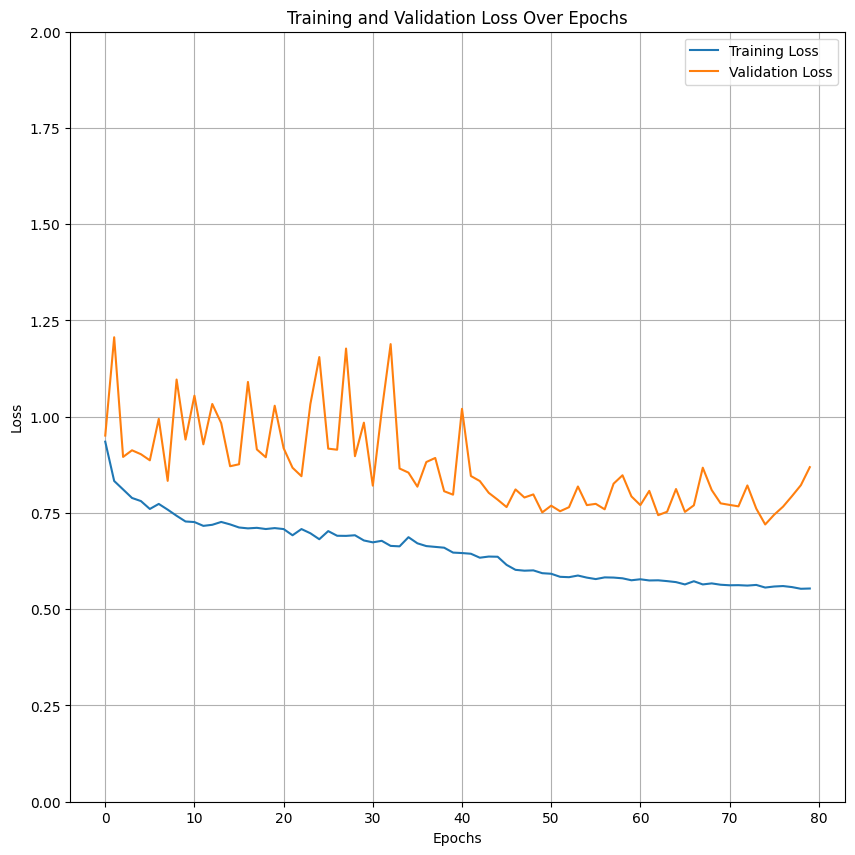

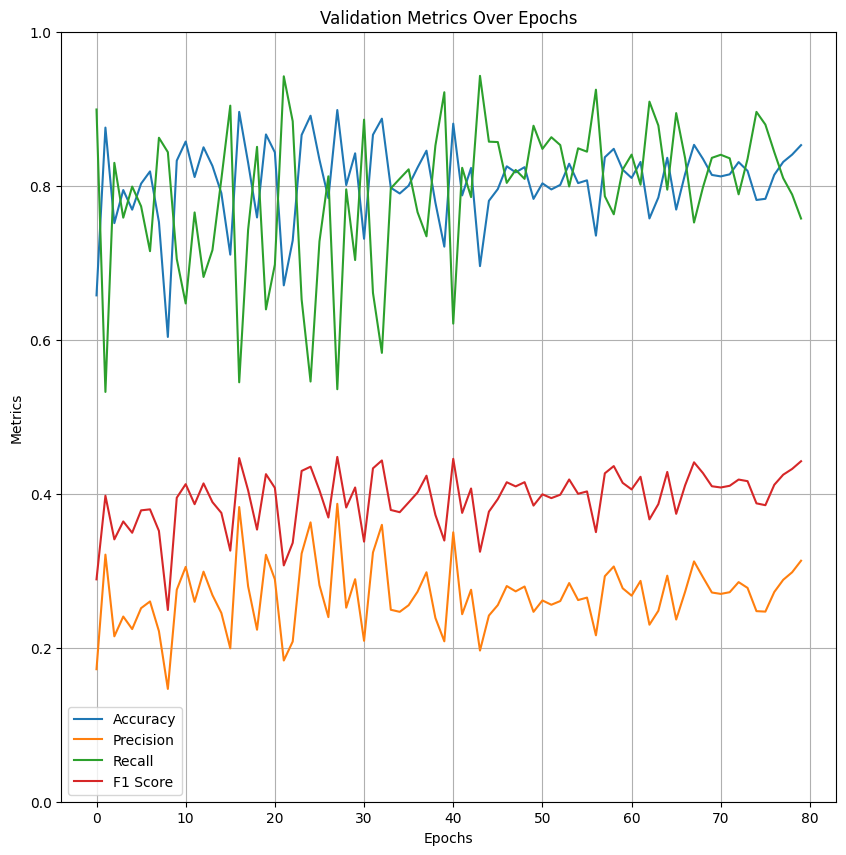

In [14]:
def visualize_metrics(data, output_dir=None):
    epochs = data["epochs"]

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, data["training_loss"], label="Training Loss")
    plt.plot(epochs, data["validation_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 2)
    if output_dir:
        plt.savefig(os.path.join(output_dir, "loss_curve.png"))
    else:
        plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, data["accuracy"], label="Accuracy")
    plt.plot(epochs, data["precision"], label="Precision")
    plt.plot(epochs, data["recall"], label="Recall")
    plt.plot(epochs, data["f1_score"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if output_dir:
        plt.savefig(os.path.join(output_dir, "metrics.png"))
    else:
        plt.show()


def parse_metrics(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = {
        "epochs": [],
        "training_loss": [],
        "validation_loss": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    current_epoch = 0
    for line in lines:
        line = line.strip()
        if line.startswith("Train Loss:"):
            data["epochs"].append(current_epoch)
            data["training_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Validation Loss:"):
            data["validation_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Accuracy:"):
            data["accuracy"].append(float(line.split(":")[1].strip()) / 100)
        elif line.startswith("Precision:"):
            data["precision"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Recall:"):
            data["recall"].append(float(line.split(":")[1].strip()))
        elif line.startswith("F1 Score:"):
            data["f1_score"].append(float(line.split(":")[1].strip()))
            current_epoch += 1

    return data


metrics_data = parse_metrics(model_dir + "/output/output.txt")
output_directory = os.path.join(model_dir, "graphs")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
visualize_metrics(metrics_data, output_dir=output_directory)


Test set

In [16]:
model1_path = os.path.join(model_dir, "better_models", "model_1", "best_model.pth.tar")
model2_path = os.path.join(model_dir, "better_models", "model_2", "best_model.pth.tar")
model3_path = os.path.join(model_dir, "better_models", "model_3", "best_model.pth.tar")

model1 = UNET(in_channels=4, out_channels=1).to(device)
model2 = UNET(in_channels=4, out_channels=1).to(device)
model3 = UNET(in_channels=4, out_channels=1).to(device)

load_model_checkpoint(torch.load(model1_path), model1)
load_model_checkpoint(torch.load(model2_path), model2)
load_model_checkpoint(torch.load(model3_path), model3)


test_transform = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2(),
])

dataset_test = SN7Dataset(image_dir_test, mask_dir_test, transform=test_transform, mean=mean, std=std)
loader_test = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


Best score with confusion matrix

-------------------------Model 1-------------------------
Number epochs: 40, lr: '0.0003293572220747851' l2: '0.0004508784371565647'

Validation Loss: 0.6231
Accuracy: 87.32
Precision: 0.2722
Recall: 0.7962
F1 Score: 0.4050

-------------------------Model 2-------------------------
Number epochs: 50, lr: '0.002386066925758022' l2: '0.0006654086822444693'

Validation Loss: 0.8538
Accuracy: 91.55
Precision: 0.3355
Recall: 0.5604
F1 Score: 0.4185

-------------------------Model 3-------------------------
Number epochs: 80, lr: '0.0009157166864196702' l2: '0.005317745339497608'

Validation Loss: 0.8887
Accuracy: 91.95
Precision: 0.3461
Recall: 0.5235
F1 Score: 0.4145


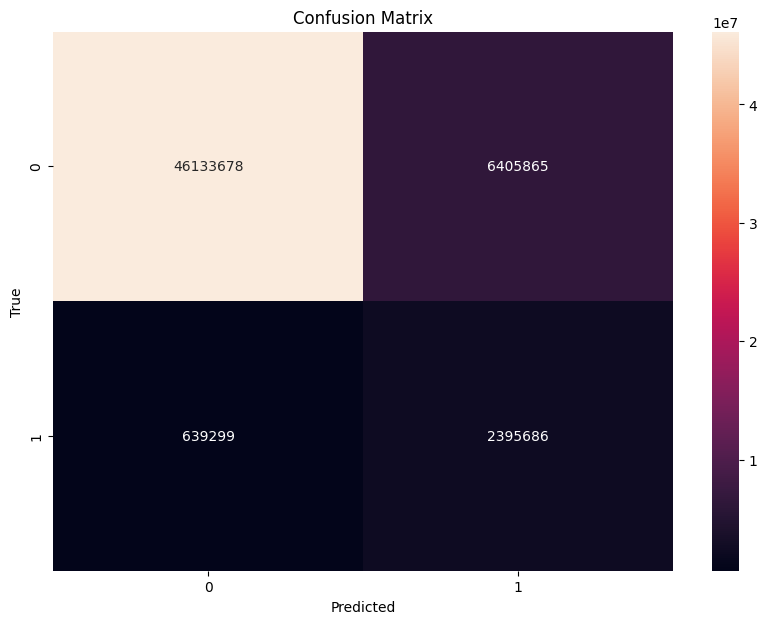

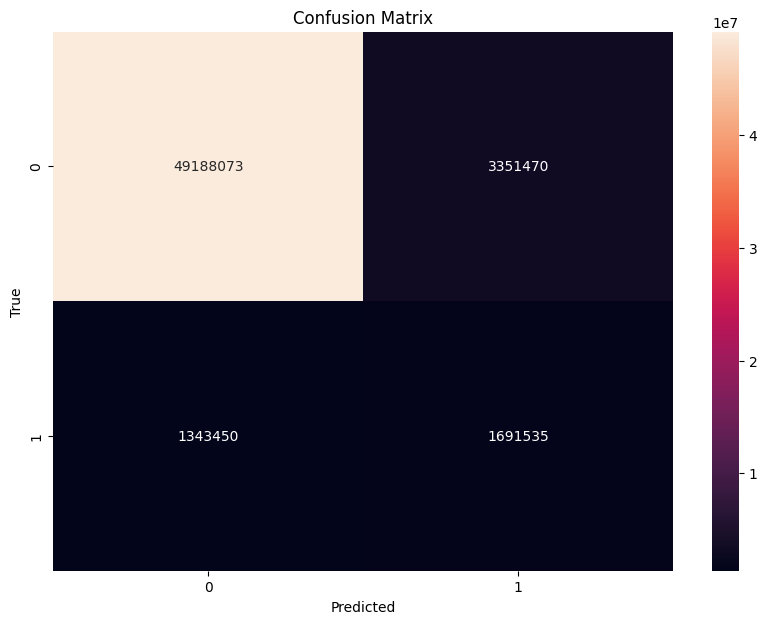

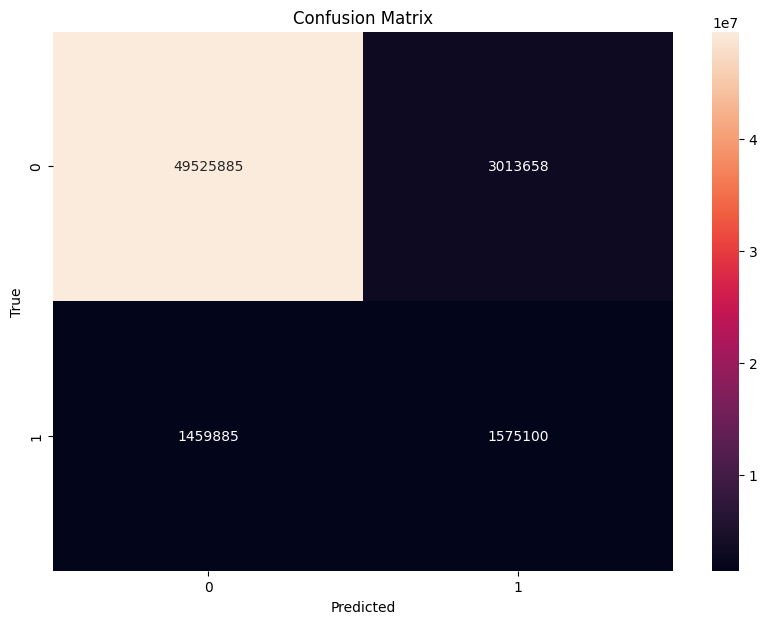

In [26]:
print("-"*25 + "Model 1" + "-"*25)
print("Number epochs: 40, lr: '0.0003293572220747851' l2: '0.0004508784371565647'\n")
loss_test1, accuracy_test1, precision_test1, recall_test1, f1_test1 = evaluation_nn(loader_test, model1, type_loss, os.path.join(output_dir, "output_test_model1.txt"), device=device, is_testing=True)
print("\n" + "-"*25 + "Model 2" + "-"*25)
print("Number epochs: 50, lr: '0.002386066925758022' l2: '0.0006654086822444693'\n")

loss_test2, accuracy_test2, precision_test2, recall_test2, f1_test2 = evaluation_nn(loader_test, model2, type_loss, os.path.join(output_dir, "output_test_model2.txt"), device=device, is_testing=True)
print("\n" + "-"*25 + "Model 3" + "-"*25)
print("Number epochs: 80, lr: '0.0009157166864196702' l2: '0.005317745339497608'\n")
loss_test3, accuracy_test3, precision_test3, recall_test3, f1_test3 = evaluation_nn(loader_test, model3, type_loss, os.path.join(output_dir, "output_test_model_3.txt"), device=device, is_testing=True)